In [1]:
%pylab inline
from scipy.stats import gaussian_kde
import tensorflow as tf
import pandas as pd
import simulate
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(device_lib.list_local_devices())

def add_sequential_indices(dataframe, keymap=None):
    if keymap is None:
        keymap = {
            'IMAGENUMBER': 'IMAGEINDEX', 
            'PHINUMBER'  : 'PHIINDEX', 
            'RUN'        : 'RUNINDEX',
        }
    df = dataframe.reset_index()
    for key,newkey in keymap.items():
        df[newkey] = np.array(pd.DataFrame(np.sort(np.unique(df[key]))).reset_index().set_index(0).loc[df[key]])
    del df['level_0']
    return df

def pare_data(dataframe):
    """Remove reflection observations from which gammas cannot be estimated due to missing on or off reflections."""
    indexnames = dataframe.index.names
    df = dataframe.reset_index().set_index(['H', 'K', 'L', 'RUN', 'PHINUMBER'])
    df = df.loc[df[df.SERIES.str.contains('on')].index.intersection(df[df.SERIES.str.contains('off')].index)]
    if None not in indexnames:
        return df.reset_index().set_index(indexnames)
    else:
        return df.reset_index()

def image_metadata(dataframe, keys = None):
    """Aggregate the image metadata from an integration run into a separate dataframe"""
    if keys is None:
        keys = [k for k in dataframe.keys() if 'ipm' in k.lower()]
        specifically_check = ['Io', 'BEAMX', 'BEAMY', 'Icryst', 'SERIES', 'RUNINDEX']
        for k in specifically_check:
            if k in dataframe:
                keys.append(k)
    return dataframe[['IMAGEINDEX'] + list(keys)].groupby('IMAGEINDEX').mean()

def get_raw_gammas(dataframe):
    """Compute uncorrected intensity ratios, return (raw gamma array, indexing array)"""
    I = pare_data(dataframe)
    iobs        = I.pivot_table(values='IOBS', index=['H', 'K', 'L', 'RUNINDEX', 'PHIINDEX'], columns='SERIES', fill_value=np.NaN) 
    imagenumber = I.pivot_table(values='IMAGEINDEX', index=['H', 'K', 'L', 'RUNINDEX', 'PHIINDEX'], columns='SERIES', fill_value=-1)
    gammas = iobs[[i for i in iobs if 'on' in i]].sum(1) / iobs[[i for i in iobs if 'off' in i]].sum(1)
    return gammas, imagenumber


Populating the interactive namespace from numpy and matplotlib


/n/home04/kmdalton/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4983176703523839157
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4541251584
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 18307797938158972444
physical_device_desc: "device: 0, name: Tesla K20m, pci bus id: 0000:42:00.0, compute capability: 3.5"
]


In [2]:
#I = simulate.build_model("test/1ubq.pdb.hkl", "test/1ubq-flip.pdb.hkl", multiplicity = 2.0, missing=0.7)
#I.to_csv("test/medium_data.csv")
I = pd.read_csv("test/big_data.csv")
#I = I.sample(frac=0.2)
#I = simulate.build_model("test/1ubq.pdb.hkl", "test/1ubq-flip.pdb.hkl", multiplicity = 100.0, missing=0.7)
#I.to_csv("test/big_data.csv")

In [67]:
tf.reset_default_graph()

data = add_sequential_indices(pare_data(I))
gammas,imagenumber = get_raw_gammas(data)

#h is a dataframe that maps each h,k,l to a unique integer
h = gammas.reset_index()[['H','K','L']].drop_duplicates().reset_index(drop=True).reset_index().pivot_table(index=['H','K','L'], values='index')

gammaidx = h.loc[gammas.reset_index().set_index(['H', 'K', 'L']).index]

In [66]:
(imagenumber[[i for i in imagenumber if 'off' in i]] > 0).sum(1).min()

0

In [68]:
r = len(gammas.reset_index().groupby('RUNINDEX'))
M = image_metadata(data)
runidx = np.array(M['RUNINDEX'])

#We need two sparse tensors to map from Icryst estimates into the liklihood function. 
tmp = np.array(imagenumber[[i for i in imagenumber if 'on' in i]])
idx = np.vstack((np.indices(tmp.shape)[0][tmp >= 0], tmp[tmp >= 0])).T
onimageidx = tf.SparseTensor(idx, np.ones(len(idx), dtype=np.float32), (len(imagenumber), len(M)))
onimageidx = tf.sparse_reorder(onimageidx)
tmp = np.array(imagenumber[[i for i in imagenumber if 'off' in i]])
idx = np.vstack((np.indices(tmp.shape)[0][tmp >= 0], tmp[tmp >= 0])).T
offimageidx = tf.SparseTensor(idx, np.ones(len(idx), dtype=np.float32), (len(imagenumber), len(M)))
offimageidx = tf.sparse_reorder(offimageidx)

#Constants 
raw_gammas = tf.constant(np.float32(gammas))
ipm        = tf.constant(np.float32(M['Io']))
ipm_x      = tf.constant(np.float32(M['IPM_X']))
ipm_y      = tf.constant(np.float32(M['IPM_Y']))


In [69]:
#Regularization strength
rho = tf.placeholder(tf.float32)

#LCs for scaling IPM data
x_intercept   = tf.Variable(0.)
x_slope       = tf.Variable(100.)
y_intercept   = tf.Variable(0.)
y_slope       = tf.Variable(100.)
ipm_intercept = tf.Variable(0.1)
ipm_slope     = tf.Variable(1.)

#Beam shape
sigx          = tf.Variable(10.)
sigy          = tf.Variable(10.)

#Crystal dimensions
xmin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
xmax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))
ymin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
ymax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))

#gammastimates
gamma         = tf.Variable(np.ones(len(h), dtype=np.float32))

beamx  = ipm_x * x_slope + x_intercept
beamy  = ipm_y * y_slope + y_intercept


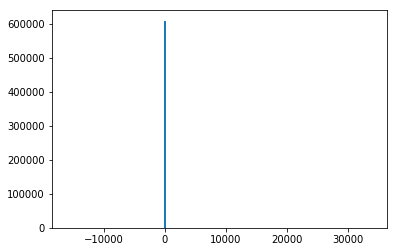

In [56]:
_ = hist(gammas, 200)

In [70]:
Icryst = 0.25*(ipm_slope*ipm + ipm_intercept) * (
    tf.erf((tf.gather(xmin, runidx) - beamx)/sigx) - tf.erf((tf.gather(xmax, runidx) - beamx)/sigx)
    ) * (
    tf.erf((tf.gather(ymin, runidx) - beamy)/sigy) - tf.erf((tf.gather(ymax, runidx) - beamy)/sigy)
    )


In [71]:
Bon  = tf.sparse_tensor_dense_matmul( onimageidx, tf.expand_dims(Icryst, 1)) 
Boff = tf.sparse_tensor_dense_matmul(offimageidx, tf.expand_dims(Icryst, 1)) 

absolute_deviation = (1./len(gammaidx))* \
    tf.reduce_sum(tf.abs(
        tf.squeeze(
            tf.square(tf.gather(gamma, gammaidx)) * \
            tf.sparse_tensor_dense_matmul(onimageidx, tf.expand_dims(Icryst, 1)) /\
            tf.sparse_tensor_dense_matmul(offimageidx, tf.expand_dims(Icryst, 1)) 
        ) - raw_gammas
    ))

"""
absolute_deviation = (1./len(gammaidx))* \
    tf.reduce_sum(tf.abs(
        tf.square(tf.gather(gamma, gammaidx)) - 
        raw_gammas * tf.sparse_tensor_dense_matmul(offimageidx, tf.expand_dims(Icryst, 1)) / tf.sparse_tensor_dense_matmul(onimageidx, tf.expand_dims(Icryst, 1))
    ))
"""


regularizer = (1./len(h))*tf.reduce_sum(tf.abs(gamma - 1.))

loss = (1. - rho)*absolute_deviation + rho*regularizer

0: 1.0424870252609253


No handles with labels found to put in legend.


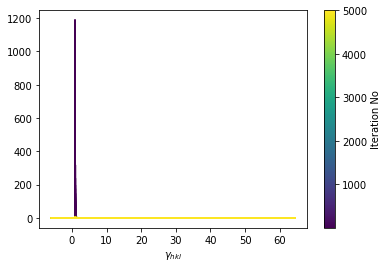

<Figure size 432x288 with 0 Axes>

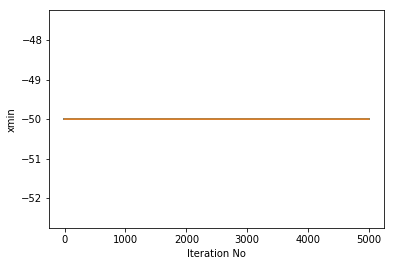

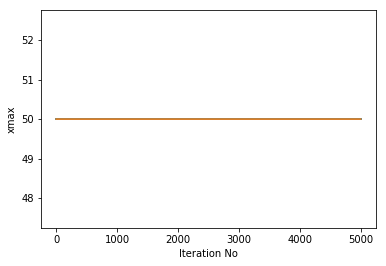

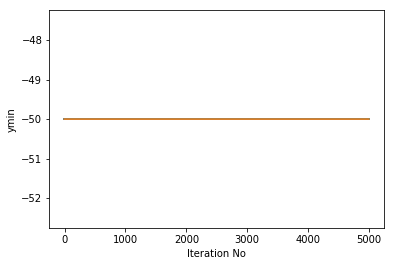

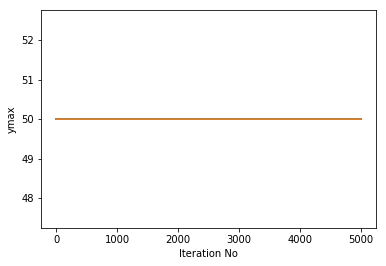

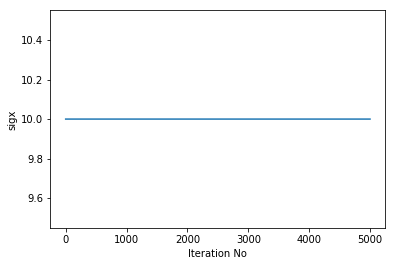

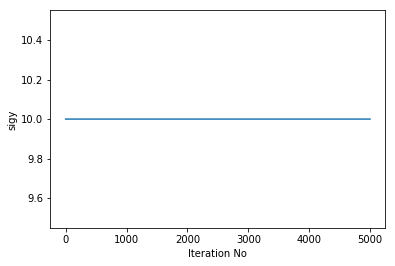

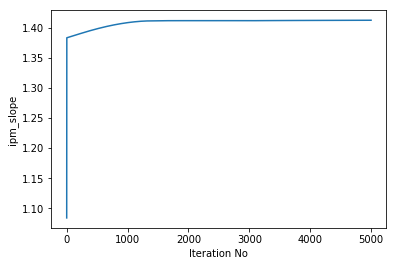

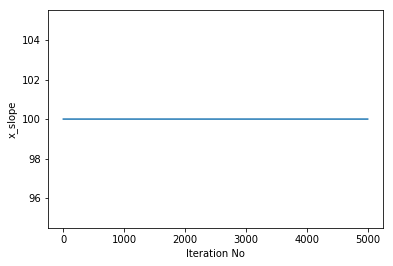

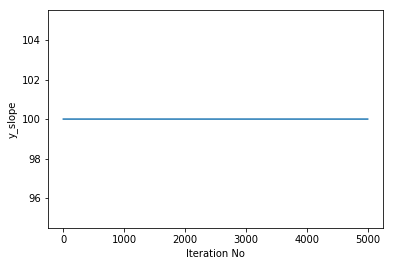

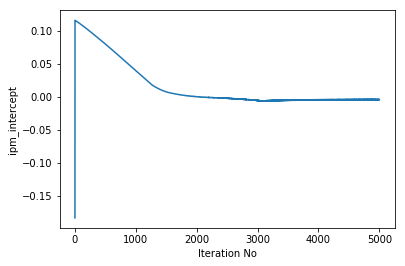

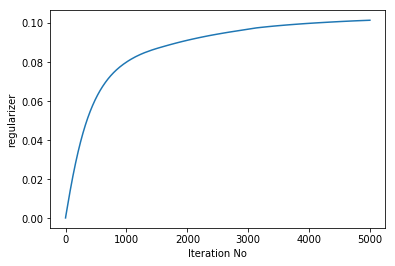

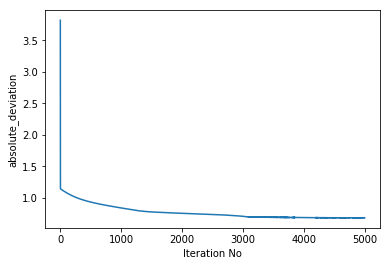

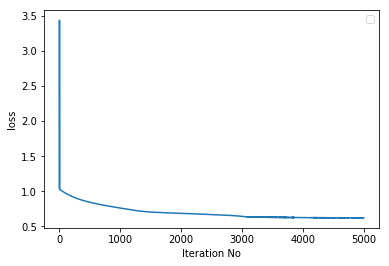

In [80]:
optimizer = tf.train.AdagradOptimizer(0.3)
train_step = optimizer.minimize(loss)

nsteps = 5000
verbose=False
cmap = plt.get_cmap()
norm = plt.Normalize(vmin=1., vmax=nsteps)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array((1., nsteps))

rhoval = .1


logvars = {
    'xmin': xmin,
    'xmax': xmax,
    'ymin': ymin,
    'ymax': ymax,
    'sigx': sigx,
    'sigy': sigy,
    'ipm_slope' : ipm_slope, 
    'x_slope' : x_slope, 
    'y_slope' : y_slope, 
    'ipm_intercept' : ipm_intercept, 
    'regularizer' : regularizer,
    'absolute_deviation' : absolute_deviation,
}

L = {k:[] for k in logvars}
L['loss'] = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("0: {}".format(sess.run(loss, {rho: rhoval})))
    for i in range(nsteps):
        _, loss_ = sess.run((train_step, loss),feed_dict={rho: rhoval})
        if i+1 % 100 == 0:
            print("{}: {}".format(i+1, loss_))
        if np.isnan(loss_):
            break
        L['loss'].append(loss_)
        gamma_   = np.square(sess.run(gamma, {rho: rhoval}))
        x1, x2 = gamma_.min(),gamma_.max()
        X = np.linspace(x1 - 0.1*(x2 - x1), x2 + 0.1*(x2 - x1), 200)
        plt.plot(X, gaussian_kde(gamma_)(X), c=sm.to_rgba(i+1))
        for k,v in logvars.items():
            L[k].append(sess.run(v, {rho: rhoval}))
        

plt.colorbar(sm, ax=plt.gca(), label='Iteration No')
plt.xlabel('$\gamma_{hkl}$')

plt.figure()
for k,v in L.items():
    plt.figure()
    plt.plot(v)
    plt.ylabel(k)
    plt.xlabel('Iteration No')
plt.legend()

Text(0.5,0,'$\\frac{\\Delta F_h} {F^{off}_h}$')

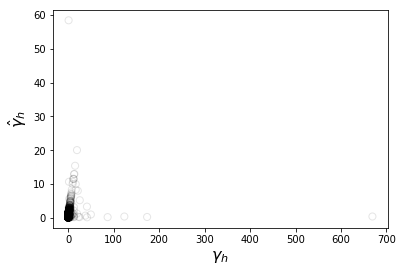

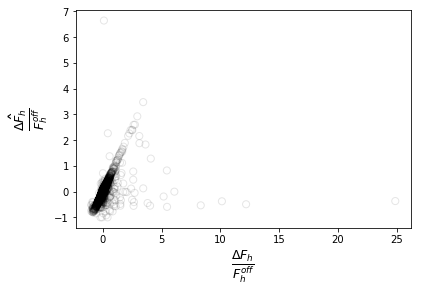

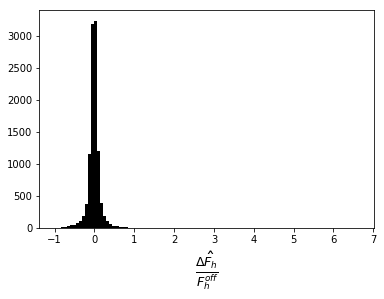

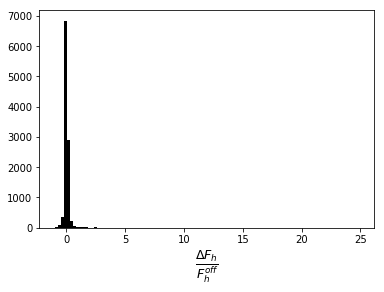

In [81]:

scatter(data.set_index(['H', 'K', 'L']).loc[h.index]['gamma'].drop_duplicates(), gamma_, edgecolors='k', facecolors='none', s=50, alpha=0.1)
plt.xlabel(r"$\gamma _h$", fontsize = 16)
plt.ylabel(r"$\hat\gamma _h$", fontsize = 16)

plt.figure()
scatter(np.sqrt(data.set_index(['H', 'K', 'L']).loc[h.index]['gamma'].drop_duplicates())-1, np.sqrt(gamma_)-1, edgecolors='k', facecolors='none', s=50, alpha=0.1)
#plt.xlabel(r"$1 - \sqrt{\gamma _h}$", fontsize = 16)
#plt.ylabel(r"$1 - \sqrt{\hat\gamma _h}$", fontsize = 16)
plt.xlabel(r"$\frac{\Delta F_h} {F^{off}_h}$", fontsize=18)
plt.ylabel(r"$\hat{\frac{\Delta F_h} {F^{off}_h}}$", fontsize=18)

plt.figure()
_ = plt.hist(np.sqrt(gamma_) - 1, 100, color='k')
plt.xlabel(r"$\hat{\frac{\Delta F_h} {F^{off}_h}}$", fontsize=18)

plt.figure()
_ = plt.hist(np.sqrt(data.set_index(['H', 'K', 'L']).loc[h.index]['gamma'].drop_duplicates())-1, 100, color='k')
plt.xlabel(r"$\frac{\Delta F_h} {F^{off}_h}$", fontsize=18)